In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import PIL as pil
from PIL import Image
import os
import seaborn as sns

In [34]:
images_path = "../Dataset/dataset/"

# define function to get all the images in a folder
def get_images(path):
    images = []
    for image in os.listdir(path):
        images.append(image)
    return images



# function to rename files to a more readable format
def rename_files(file_names):
    for i in range(len(file_names)):
        os.rename(images_path + file_names[i], images_path + file_names[i].lower())


def create_path_df(path):
    # get all the images in the folder
    images = get_images(path)
    # create a dataframe with the image names
    df = pd.DataFrame(images, columns=["image_name"])
    # create a column with the path to the image
    df["image_path"] = path + df["image_name"]

    # sort the dataframe by the image name
    df['image_name'] = df['image_name'].str.replace('.jpg', '').astype(int)
    df = df.sort_values(by=['image_name'])
    df["image_name"] = df["image_name"].apply(lambda x: f"{x}.jpg")
    df["Case Number"] = df["image_name"].str.split(".").str[0]
    df["Case Number"] = df["Case Number"].astype(int)
    df = df.drop(columns=["image_name"])

    # make index case number
    df = df.set_index("Case Number")
    return df

# rename_files(get_images(images_path))

path_df = create_path_df(images_path)
path_df

,image_path
Case Number,
1,../Dataset/dataset/1.jpg
2,../Dataset/dataset/2.jpg
3,../Dataset/dataset/3.jpg
4,../Dataset/dataset/4.jpg
5,../Dataset/dataset/5.jpg
...,...
186,../Dataset/dataset/186.jpg
187,../Dataset/dataset/187.jpg
188,../Dataset/dataset/188.jpg


In [35]:
# csv locs

data_loc = "../Dataset/"

# load left and right cases csvs
left_cases = pd.read_csv(data_loc + "left_cases.csv", index_col="Case Number")
right_cases = pd.read_csv(data_loc + "right_cases.csv", index_col="Case Number")


In [36]:
# rename columns

def rename_cols(df):
    df.columns = [f"parameter_{i}" for i in range(1, len(df.columns) + 1)]
    return df

def fill_nan(df):
    df = df.fillna("None")
    return df


def fix_entries(df):
    df = df.replace("Good ", "Good")
    df = df.replace("Poor ", "Poor")
    df = df.replace("Goo", "Good")
    df = df.replace("Goo ", "Good")
    df = df.replace("Average ", "Average")
    return df

def get_distribution_per_param(df):
    for col in df.columns:
        print(col)
        plt.hist(df[col])
        plt.show()

def join_dfs(left_df, right_df, rename=True):

    # rename columns in left and right
    if rename:
        left_df.columns = [f"left_{col}" for col in left_df.columns]
        right_df.columns = [f"right_{col}" for col in right_df.columns]
    df = pd.concat([left_df, right_df], axis=1)
    df = df.reset_index()
    df = df.rename(columns={"index": "Case Number"})
    df = df.set_index("Case Number")
    return df

left_cases = fix_entries(fill_nan(rename_cols(left_cases)))
right_cases = fix_entries(fill_nan(rename_cols(right_cases)))

cases = join_dfs(left_cases, right_cases)
cases = join_dfs(cases, path_df, rename=False)
cases
# get_distribution_per_param(left_cases)

,left_parameter_1,left_parameter_2,left_parameter_3,left_parameter_4,right_parameter_1,right_parameter_2,right_parameter_3,right_parameter_4,image_path
Case Number,,,,,,,,,
1,Poor,Average,Poor,Poor,None,None,None,None,../Dataset/dataset/1.jpg
2,Good,Good,Good,Good,Good,Good,Good,Good,../Dataset/dataset/2.jpg
3,Poor,Good,Poor,Average,None,None,None,None,../Dataset/dataset/3.jpg
4,Average,Good,Good,Average,None,None,None,None,../Dataset/dataset/4.jpg
5,None,None,None,None,Poor,Good,Poor,Average,../Dataset/dataset/5.jpg
...,...,...,...,...,...,...,...,...,...
186,None,None,None,None,Good,Good,Good,Average,../Dataset/dataset/186.jpg
187,Good,Good,Average,Good,None,None,None,None,../Dataset/dataset/187.jpg
188,Poor,Good,Poor,Good,None,None,None,None,../Dataset/dataset/188.jpg


In [66]:
class_dist

{'left': {'parameter_1': {'Poor': 49, 'Good': 35, 'Average': 35},
  'parameter_2': {'Good': 87, 'Average': 25, 'Poor': 7},
  'parameter_3': {'Good': 50, 'Poor': 39, 'Average': 30},
  'parameter_4': {'Average': 74, 'Good': 29, 'Poor': 16}},
 'right': {'parameter_1': {'Good': 48, 'Poor': 46, 'Average': 38},
  'parameter_2': {'Good': 92, 'Average': 30, 'Poor': 10},
  'parameter_3': {'Good': 62, 'Poor': 54, 'Average': 16},
  'parameter_4': {'Average': 67, 'Good': 50, 'Poor': 15}}}

c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

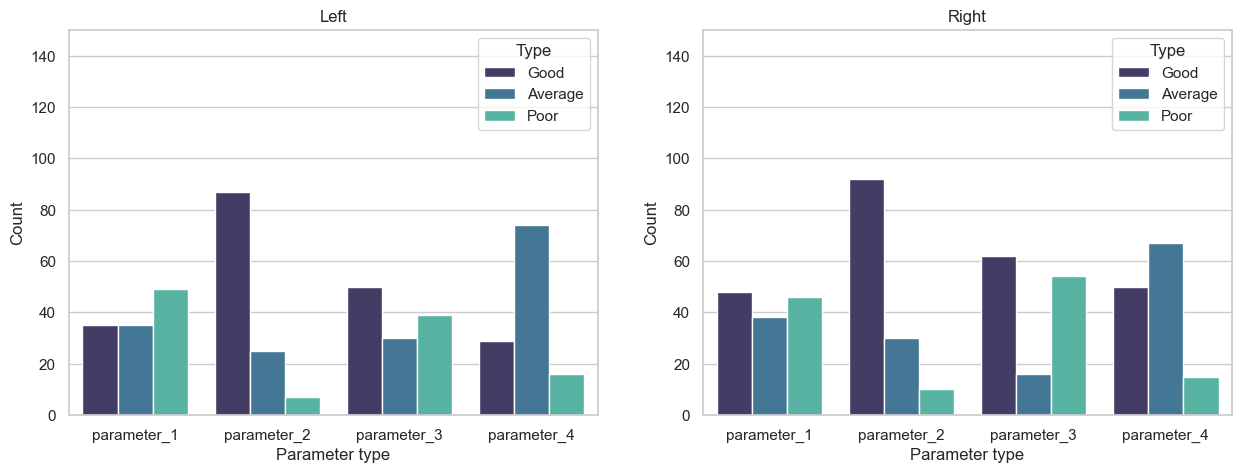

In [79]:
# get the distribution of classes in each parameter for left and right cases as a dictionary
def get_dist_per_side_per_param(df):
    
    dist_dict = {}
    dist_dict["left"] = {}
    dist_dict["right"] = {}

    for col in df.columns:
        if col.startswith("left"):
            dist_dict["left"][col.replace("left_", "")] = df[col].value_counts().to_dict()
        elif col.startswith("right"):
            dist_dict["right"][col.replace("right_", "")] = df[col].value_counts().to_dict()

    # keep only Good, Poor and Average
    for side in dist_dict.keys():
        for param in dist_dict[side].keys():
            for key in list(dist_dict[side][param].keys()):
                if key not in ["Good", "Poor", "Average"]:
                    dist_dict[side][param].pop(key, None)


    return dist_dict

class_dist = get_dist_per_side_per_param(cases)

def plot_distributions(dist_dict):
    
    sns.set_theme(style="whitegrid")

    categories = [f"parameter_{i}" for i in range(1, 5)]
    types = ["Good", "Average", "Poor"]

    # create two subplots, one for each side
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    values = {}
    values["left"] = {}
    values["right"] = {}

    for side in dist_dict.keys():
        for type in types:
            values[side][type] = []
            for param in categories:
                if type in dist_dict[side][param].keys():
                    values[side][type].append(dist_dict[side][param][type])
                else:
                    values[side][type].append(0)

    df_left = pd.DataFrame(values["left"], index=categories).T.reset_index().melt(id_vars=["index"], value_vars=categories)
    df_left.columns = ["Type", "Category", "Count"]
    df_right = pd.DataFrame(values["right"], index=categories).T.reset_index().melt(id_vars=["index"], value_vars=categories)
    df_right.columns = ["Type", "Category", "Count"]
    axs[0] = sns.barplot(x="Category", y="Count", hue="Type", data=df_left, ax=axs[0], palette="mako")
    axs[1] = sns.barplot(x="Category", y="Count", hue="Type", data=df_right, ax=axs[1], palette="mako")
    axs[0].set_title("Left")
    axs[1].set_title("Right")
    # set x label to "Parameter type"
    axs[0].set_xlabel("Parameter type")
    axs[1].set_xlabel("Parameter type")
    # set y limit from 0 to 150
    axs[0].set_ylim(0, 150)
    axs[1].set_ylim(0, 150)

plot_distributions(class_dist)

c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hamad\anaconda3\envs\allaa\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

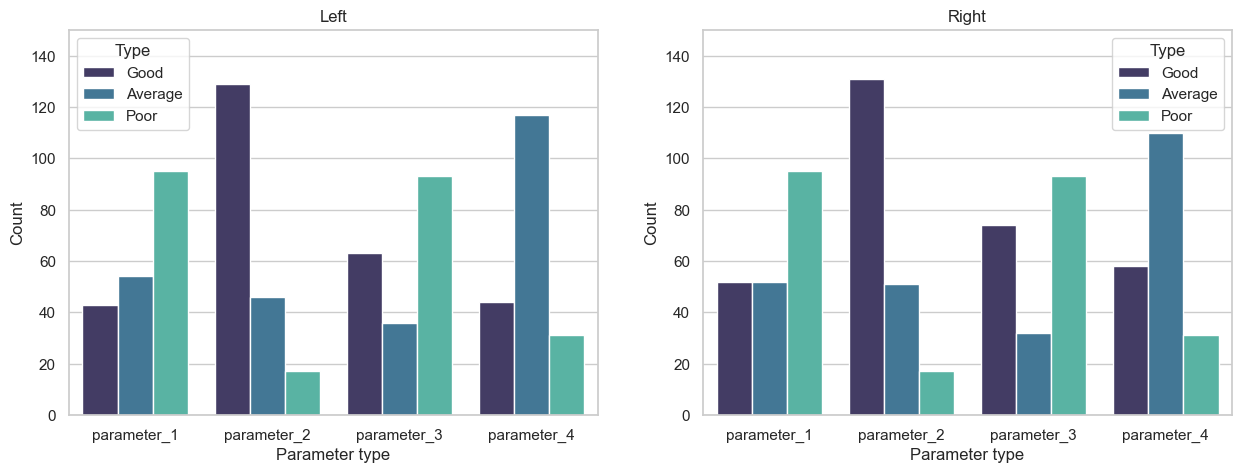

In [80]:
class_dist_augmented = get_dist_per_side_per_param(augmented_df)
plot_distributions(class_dist_augmented)